## Imports and config

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "0, 1" for multiple
# http://forums.fast.ai/t/tip-limiting-tensorflow-to-one-gpu/1995

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy
import skimage.transform

import keras

from keras import backend as K  # set the data format as 'channels_first'

from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras import applications  # VGG model

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional, concatenate
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
#from keras.regularizers import l2, activity_l2, l1, activity_l1

from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
#from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy

from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint, EarlyStopping  # callbacks

from keras.preprocessing.image import ImageDataGenerator

from glob import glob
import os
import bcolz
import ujson as json
import PIL

from scipy import ndimage
from collections import defaultdict

# import h5py

Using TensorFlow backend.


In [15]:
# Set path to the current path
PATH_IMAGES = "/home/julien/labels_experiments_heatmaps/"
batch_size = 32

In [4]:
# from keras import applications
# from keras import backend as K  # TODO : perhaps change
K.set_image_dim_ordering('th')
print(K._BACKEND)
print(K.image_data_format())

tensorflow
channels_first


In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
all_results = defaultdict(dict)

## Bounding boxes

In [30]:
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1)#.astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3)#.astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))

In [ ]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i, val_bbox):
    bb = val_bbox[i]
    # print(bb)
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

## Visualization

In [ ]:
def show_image_heatmap(index, val_bbox, cm):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    show_bb(index, val_bbox)
    plt.subplot(1, 2, 2)
    plt.imshow(cm, cmap="hot")

In [16]:
target_size = (360,640)

In [17]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

train_generator = train_datagen.flow_from_directory(
    directory=PATH_IMAGES+"train/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 34564 images belonging to 2 classes.


In [18]:
valid_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

valid_generator = valid_datagen.flow_from_directory(
    directory=PATH_IMAGES+"val/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 4000 images belonging to 2 classes.


In [118]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATH_IMAGES+"test/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 4000 images belonging to 2 classes.


## VGG model with size (224,224) version 2

In [10]:
base_model = applications.VGG16(include_top=False, weights='imagenet')#, input_shape=(3,)+target_size)

i=0
for layer in base_model.layers:
    layer.trainable = False
    i = i+1
    print(i,layer.name)

1 input_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/keras/applications/vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


### Top-model, low-resolution

In [11]:
nf=128; p=0.

x = base_model.output
x = BatchNormalization(axis=1)(x)
x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D()(x)
x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D()(x)
x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
#x = MaxPooling2D((1,2))(x)
#x = MaxPooling2D()(x)
x = Convolution2D(2,(3,3), padding='same')(x)
#x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
predictions = Activation('softmax')(x)

In [11]:
x = base_model.output
#x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='sigmoid')(x)

In [12]:
#checkpointer = ModelCheckpoint(filepath=path+'results/models/top_model_low_res_224.hdf5',
#                               verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath='./results/models/low_res_224.hdf5',
                               verbose=1, save_best_only=True)    
earlystop = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpointer, earlystop]

In [17]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size  # 7292
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size  # 156
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

540
62


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [18]:
model.fit_generator(
        train_generator,
        steps_per_epoch=540,
        epochs=100,
        #callbacks = callbacks_list,
        validation_data = valid_generator,
        validation_steps=62,
        #callbacks=callbacks_list
        )

Epoch 1/100
 31/540 [>.............................] - ETA: 9:25 - loss: 0.3916 - acc: 0.8291

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


540/540 [==============================] - 645s 1s/step - loss: 0.2758 - acc: 0.8804 - val_loss: 0.2203 - val_acc: 0.9115
Epoch 2/100
 31/540 [>.............................] - ETA: 8:57 - loss: 0.2024 - acc: 0.9189

KeyboardInterrupt: 

In [ ]:
# top_model.summary()

In [ ]:
top_model.fit(conv_trn_feat_224, trn_labels, batch_size=batch_size, epochs=20, 
             validation_data=(conv_val_feat_224, val_labels),
             callbacks=callbacks_list)

In [ ]:
# dropout=0 ==> val_loss=0.15260, 0.13566, 0.12553, 0.14417, 0.17049
# dropout=0.1 == > val_loss=0.15995
# dropout=0.2 == > val_loss=0.15975
# dropout=0.3 == > val_loss=0.15890

In [19]:
model.evaluate_generator(
    test_generator,
    steps=62
)

[0.1908304953887578, 0.9198588709677419]

In [ ]:
top_model.load_weights(filepath=path+'results/models/top_model_low_res_224.hdf5')
top_model.evaluate(conv_val_feat_224, val_labels, batch_size=batch_size)

### Reload results (top-model, low-resolution)

If the results have been computed before.

In [ ]:
conv_trn_feat_224 = load_array(path+'results/vgg/con_trn_feat_224.dat')
conv_val_feat_224 = load_array(path+'results/vgg/conv_val_feat_224.dat')

In [ ]:
nf=128; p=0.
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_trn_feat_224.shape[1:]),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,(3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

top_model = Sequential(get_lrg_layers())
top_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

top_model.load_weights(filepath=path+'results/models/top_model_low_res_224.hdf5')

In [ ]:
loss, acc = top_model.evaluate(conv_val_feat_224, val_labels, batch_size=batch_size)
print(loss, acc)
all_results["VGG model, size=(224,224), with Maxpooling"]["validation accuracy"] = np.round(acc, 2)

### Results

In [ ]:
def select_top_k(cm, k):
    return np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]


def get_cm(inp, label, conv_output, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_output([inp,0])[0][0, label]
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)


# Compute all the inps.
# Compute all the cms.
# Select the k pixel coordinates with the lowest values.
# Check if those coordinates are inside the bounding box.
# Compute the total p@k.
# (We can store the p@k for every image in a list).

def get_all_cms(conv_val_feat, model):
    l = top_model.layers
    conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    
    index_range = conv_val_feat.shape[0]
    # print(index_range)
    inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    
    cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    return cms


def total_p_at_k(cms, val_bbox, k):
    # l = top_model.layers
    # conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    # 
    index_range = len(cms)
    # # print(index_range)
    # inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    # labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    # 
    # cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    top_ks = [select_top_k(cm, k) for cm in cms]
    
    #return top_ks
    
    #print("bounding box")
    xmins = [val_bbox[index][2] for index in range(index_range)]
    xmaxs = [val_bbox[index][2] + val_bbox[index][1] for index in range(index_range)]
    ymins = [val_bbox[index][3] for index in range(index_range)]
    ymaxs = [val_bbox[index][3] + val_bbox[index][0] for index in range(index_range)]
    #return [[72 <= x[1] <= 107 and 34 <= x[0] <= 55 for x in top_ks[1]]
    #             for y in top_ks]
    #print("ks_inside")
    ks_inside = [[xmin <= x[1] <= xmax and ymin <= x[0] <= ymax for x in y]
                 for y, xmin, xmax, ymin, ymax in zip(top_ks, xmins, xmaxs, ymins, ymaxs)
                 if xmin!=0 and xmax!=0 and ymin!=0 and ymax!=0]
    
    p_at_ks = [np.mean(k_inside) for k_inside in ks_inside]
    
    #print(p_at_ks)
    
    #return ks_inside
    
    return np.mean(p_at_ks)

In [ ]:
cms = get_all_cms(conv_val_feat_224, top_model)

In [ ]:
k = 1
all_results["VGG model, size=(224,224), with Maxpooling"]["p@{}".format(k)] = np.round(total_p_at_k(cms, val_bbox_224, k), 2)

In [ ]:
threshold = 150
all_results["VGG model, size=(224,224), with Maxpooling"]["ratio among region"] = np.round(p_among_region(cms, val_bbox_224, threshold), 2)
all_results["VGG model, size=(224,224), with Maxpooling"]["ratio among all regions"] = np.round(p_among_all_regions(cms, val_bbox_224, threshold), 2)

### Heatmap, low-resolution

In [64]:
l = model.layers
conv_low_res_224 = K.function([l[0].input, K.learning_phase()], [l[-3].output])
conv_low_res_224([temp1])[0].shape

In [67]:
conv_low_res_224([temp1])[0].shape

(64, 128, 1, 1)

In [22]:
def get_cm(inp, label, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_low_res_224([inp,0])[0][0, label]
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)

# def get_cm2(inp, label, target_size=target_size):
#     conv = conv_low_res_224([inp,0])[0][0, label]
#     # print(conv.shape)
#     #return scipy.misc.imresize(conv, target_size, interp='nearest')
#     return conv
#     return skimage.transform.resize(conv.astype('int'), target_size)
#     # mode='reflect' kills the kernel

def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [24]:
temp1, temp2 = test_generator.next()

In [46]:
temp1[0].shape

(3, 224, 224)

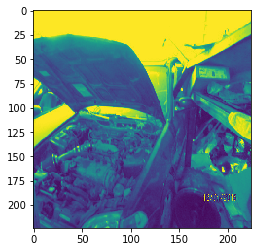

In [47]:
plt.imshow(temp1[0][0])

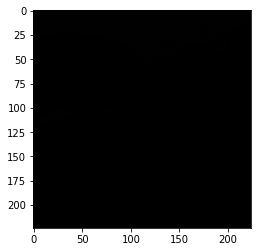

In [44]:
plot(temp1[0])

In [33]:
np.expand_dims(temp1[0], axis=0).shape

(1, 3, 224, 224)

In [53]:
type(temp1)

numpy.ndarray

In [55]:
conv_low_res_224([temp1])

[array([[[[ 2.0043252 ]],
 
         [[-1.9559128 ]]],
 
 
        [[[ 5.563185  ]],
 
         [[-4.9100275 ]]],
 
 
        [[[ 1.2646734 ]],
 
         [[-1.565716  ]]],
 
 
        [[[ 1.6345651 ]],
 
         [[-2.019126  ]]],
 
 
        [[[-0.39128405]],
 
         [[-0.45433637]]],
 
 
        [[[ 4.317512  ]],
 
         [[-4.0794134 ]]],
 
 
        [[[ 2.591757  ]],
 
         [[-2.6251273 ]]],
 
 
        [[[ 1.9881898 ]],
 
         [[-1.8828055 ]]],
 
 
        [[[ 1.1196421 ]],
 
         [[-1.0292233 ]]],
 
 
        [[[ 4.67196   ]],
 
         [[-4.365019  ]]],
 
 
        [[[ 6.338709  ]],
 
         [[-6.557065  ]]],
 
 
        [[[ 4.7426667 ]],
 
         [[-4.932918  ]]],
 
 
        [[[ 3.2329345 ]],
 
         [[-3.6882236 ]]],
 
 
        [[[ 4.3612404 ]],
 
         [[-4.5358562 ]]],
 
 
        [[[ 4.456349  ]],
 
         [[-4.3912334 ]]],
 
 
        [[[ 4.2947817 ]],
 
         [[-4.662042  ]]],
 
 
        [[[ 3.123396  ]],
 
         [[-3.3361197 ]]],
 

In [51]:
conv_low_res_224([np.expand_dims(temp1[0], axis=0)])

[array([[[[ 2.004321 ]],
 
         [[-1.9559084]]]], dtype=float32)]

In [39]:
cm_temp = get_cm(np.expand_dims(temp1[0], axis=0), 1)

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [40]:
np.unique(cm_temp)

array([0], dtype=uint8)

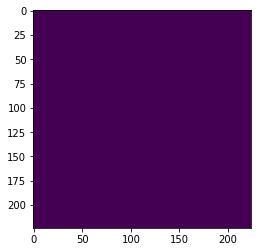

In [41]:
plt.imshow(cm_temp)

In [ ]:
index = 1

In [ ]:
inp = np.expand_dims(conv_val_feat_224[index], 0)
np.round(top_model.predict(inp)[0],2)

In [ ]:
plt.imshow(to_plot(val[index]))
#plt.show()

In [ ]:
cm = get_cm(inp, 0)

In [ ]:
plt.imshow(cm, cmap="hot")
#plt.show()

In [ ]:
cm2 = get_cm2(inp, 0)
plt.imshow(cm2, cmap="hot")
#plt.show()

The heatmap is very blurry.  
Not interesting to compute the p@k metric.

### Top-model, high-resolution

In [ ]:
conv_trn_feat_224 = load_array(path+'results/vgg/con_trn_feat_224.dat')
conv_val_feat_224 = load_array(path+'results/vgg/conv_val_feat_224.dat')

In [ ]:
# TODO : try adding dropout in the middle layers for all models.

nf=128; p=0.1
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_trn_feat_224.shape[1:]),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        #Dropout(p),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        #Dropout(p),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        #Dropout(p),
        BatchNormalization(axis=1),
        Convolution2D(8,(3,3), padding='same'),
        #Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [ ]:
top_model = Sequential(get_lrg_layers())

In [ ]:
#checkpointer = ModelCheckpoint(filepath=path+'results/models/top_model_high_res_224.hdf5',
#                               verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath=path+'results/models/tmp.hdf5',
                               verbose=1, save_best_only=True)    
earlystop = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpointer, earlystop]

In [ ]:
top_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# top_model.summary()

In [ ]:
top_model.fit(conv_trn_feat_224, trn_labels, batch_size=batch_size, epochs=20, 
             validation_data=(conv_val_feat_224, val_labels),
             callbacks=callbacks_list)

In [ ]:
# dropout=0 ==> val_loss=0.26205, 0.31395, 0.26216
# dropout=0.1 == > val_loss=
# dropout=0.2 == > val_loss=
# dropout=0.3 == > val_loss=

# with dropout added several times, val_loss=0.21672

In [ ]:
top_model.load_weights(filepath=path+'results/models/top_model_high_res_224.hdf5')
top_model.evaluate(conv_val_feat_224, val_labels, batch_size=batch_size)

### Reload results (top-model, high-resolution)

If the results have been computed before.

In [ ]:
conv_trn_feat_224 = load_array(path+'results/vgg/con_trn_feat_224.dat')
conv_val_feat_224 = load_array(path+'results/vgg/conv_val_feat_224.dat')

In [ ]:
nf=128; p=0.
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_trn_feat_224.shape[1:]),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,(3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

top_model = Sequential(get_lrg_layers())
top_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

top_model.load_weights(filepath=path+'results/models/top_model_high_res_224.hdf5')

In [ ]:
loss, acc = top_model.evaluate(conv_val_feat_224, val_labels, batch_size=batch_size)
print(loss, acc)
all_results["VGG model, size=(224,224), no Maxpooling"]["validation accuracy"] = np.round(acc, 2)

### Heatmap high-resolution

In [ ]:
l = top_model.layers
conv_high_res_224 = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [ ]:
def get_cm(inp, label, conv_output, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_output([inp,0])[0][0, label]
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)

def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [ ]:
index = 2

In [ ]:
inp = np.expand_dims(conv_val_feat_224[index], 0)
print(np.round(top_model.predict(inp)[0],2))
label = np.argmax(top_model.predict(inp)[0])

In [ ]:
plt.imshow(to_plot(val[index]))
#plt.show()

In [ ]:
show_bb(index, val_bbox_224)

In [ ]:
cm = get_cm(inp, label, conv_high_res_224)

In [ ]:
plt.imshow(cm, cmap="jet")
#plt.show()
plt.colorbar()

In [ ]:
show_image_heatmap(index, val_bbox_224, cm)

The 'hot' cmap can be deceptive if we forget that the darkest pixels are the most interesting ones.  
Perhaps the 'binary' cmap is more appropriate.

In [ ]:
plt.imshow(cm, cmap="binary")  # the lighter the better
#plt.show()
plt.colorbar()

Or use a reverse 'hot' cmap.

In [ ]:
plt.imshow(cm, cmap="hot_r")  # the lighter the better
#plt.show()
plt.colorbar()

### Results

In [ ]:
tmp = np.array([[5, 2, 4],
[3, 3, 3],
[6, 1, 2]])

np.dstack(np.unravel_index(np.argsort(tmp.ravel()), (3, 3)))

In [ ]:
np.unravel_index(np.argsort(tmp.ravel()), (3, 3))

https://stackoverflow.com/questions/30577375/have-numpy-argsort-return-an-array-of-2d-indices was useful.

In [ ]:
np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))  # axis x and y reversed
# as "reading" a value is different for a picture (x=column, y=line) 
# or for a matrix (x=line, y=column)

In [ ]:
# Take the k first coordinates (and flip them).
np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]

In [ ]:
# 'height', 'width', 'x', 'y'
# xmin
print(val_bbox[index][2])
# xmax
print(val_bbox[index][2] + val_bbox[index][1])
# ymin
print(val_bbox[index][3])
# ymax
print(val_bbox[index][3] + val_bbox[index][0])

In [ ]:
np.flip(np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][:k], 1)

In [ ]:
# def select_top_k(cm, k):
#     return np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]
# 
# 
# # Compute all the inps.
# # Compute all the cms.
# # Select the k pixel coordinates with the lowest values.
# # Check if those coordinates are inside the bounding box.
# # Compute the total p@k.
# # (We can store the p@k for every image in a list).
# 
# def total_p_at_k(conv_val_feat, model, k):
#     l = top_model.layers
#     conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
#     
#     index_range = conv_val_feat.shape[0]
#     # print(index_range)
#     inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
#     labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
#     
#     cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
#     
#     top_ks = [select_top_k(cm, k) for cm in cms]
#     
#     #return top_ks
#     
#     #print("bounding box")
#     xmins = [val_bbox_224[index][2] for index in range(index_range)]
#     xmaxs = [val_bbox_224[index][2] + val_bbox_224[index][1] for index in range(index_range)]
#     ymins = [val_bbox_224[index][3] for index in range(index_range)]
#     ymaxs = [val_bbox_224[index][3] + val_bbox_224[index][0] for index in range(index_range)]
#     #return [[72 <= x[1] <= 107 and 34 <= x[0] <= 55 for x in top_ks[1]]
#     #             for y in top_ks]
#     #print("ks_inside")
#     
#     # Remove cases with no bounding boxes (class 'no fish' for example).
#     ks_inside = [[xmin <= x[1] <= xmax and ymin <= x[0] <= ymax for x in y]
#                  for y, xmin, xmax, ymin, ymax in zip(top_ks, xmins, xmaxs, ymins, ymaxs)
#                  if xmin!=0 and xmax!=0 and ymin!=0 and ymax!=0]
#     
#     p_at_ks = [np.mean(k_inside) for k_inside in ks_inside]
#     
#     #print(p_at_ks)
#     #return p_at_ks
#     
#     return np.mean(p_at_ks)

In [ ]:
def select_top_k(cm, k):
    return np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]


# Compute all the inps.
# Compute all the cms.
# Select the k pixel coordinates with the lowest values.
# Check if those coordinates are inside the bounding box.
# Compute the total p@k.
# (We can store the p@k for every image in a list).

def get_all_cms(conv_val_feat, model):
    l = top_model.layers
    conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    
    index_range = conv_val_feat.shape[0]
    # print(index_range)
    inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    
    cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    return cms


def total_p_at_k(cms, val_bbox, k):
    # l = top_model.layers
    # conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    # 
    index_range = len(cms)
    # # print(index_range)
    # inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    # labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    # 
    # cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    top_ks = [select_top_k(cm, k) for cm in cms]
    
    #return top_ks
    
    #print("bounding box")
    xmins = [val_bbox[index][2] for index in range(index_range)]
    xmaxs = [val_bbox[index][2] + val_bbox[index][1] for index in range(index_range)]
    ymins = [val_bbox[index][3] for index in range(index_range)]
    ymaxs = [val_bbox[index][3] + val_bbox[index][0] for index in range(index_range)]
    #return [[72 <= x[1] <= 107 and 34 <= x[0] <= 55 for x in top_ks[1]]
    #             for y in top_ks]
    #print("ks_inside")
    ks_inside = [[xmin <= x[1] <= xmax and ymin <= x[0] <= ymax for x in y]
                 for y, xmin, xmax, ymin, ymax in zip(top_ks, xmins, xmaxs, ymins, ymaxs)
                 if xmin!=0 and xmax!=0 and ymin!=0 and ymax!=0]
    
    p_at_ks = [np.mean(k_inside) for k_inside in ks_inside]
    
    #print(p_at_ks)
    
    #return ks_inside
    
    return np.mean(p_at_ks)

In [ ]:
cms = get_all_cms(conv_val_feat_224, top_model)

In [ ]:
k = 1
all_results["VGG model, size=(224,224), no Maxpooling"]["p@{}".format(k)] = np.round(total_p_at_k(cms, val_bbox_224, k), 2)

In [ ]:
threshold = 150
all_results["VGG model, size=(224,224), no Maxpooling"]["ratio among region"] = np.round(p_among_region(cms, val_bbox_224, threshold), 2)
all_results["VGG model, size=(224,224), no Maxpooling"]["ratio among all regions"] = np.round(p_among_all_regions(cms, val_bbox_224, threshold), 2)

In [ ]:
all_results

In [ ]:
# 'height', 'width', 'x', 'y'
# xmin
print(val_bbox[index][2])
# xmax
print(val_bbox[index][2] + val_bbox[index][1])
# ymin
print(val_bbox[index][3])
# ymax
print(val_bbox[index][3] + val_bbox[index][0])

## VGG model with size (360,640) version 2

In [ ]:
# all_results.append({"name": "VGG model, size=(360,640)"})

### Top-model, high-resolution

In [49]:
base_model = applications.VGG16(include_top=False, weights='imagenet')#, input_shape=(3,)+target_size)
# base_model.layers.pop()
# base_model.outputs = [base_model.layers[-1].output]
# base_model.output_layers = [base_model.layers[-1]]
# base_model.layers[-1].outbound_nodes = []

i=0
for layer in base_model.layers:
    layer.trainable = False
    i = i+1
    print(i,layer.name)

1 input_4
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/keras/applications/vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [50]:
base_model.output

<tf.Tensor 'block5_pool_3/MaxPool:0' shape=(?, 512, ?, ?) dtype=float32>

In [51]:
# TODO : try adding dropout in the middle layers for all models.

nf=128; p=0.1

x = base_model.layers[-1].output
x = BatchNormalization(axis=1)(x)
x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
#Dropout(p),
x = BatchNormalization(axis=1)(x)
x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
#Dropout(p),
x = BatchNormalization(axis=1)(x)
x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
#Dropout(p),
x = BatchNormalization(axis=1)(x)
x = Convolution2D(2,(3,3), padding='same')(x)
#Dropout(p),
x = GlobalAveragePooling2D()(x)
predictions = Activation('softmax')(x)

In [52]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
checkpointer = ModelCheckpoint(filepath="/home/julien/"+'results/models/high_res_640.hdf5',
                               verbose=1, save_best_only=True)    
earlystop = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpointer, earlystop]

In [45]:
# model.summary()

In [46]:
# CHANGE THE GENERATOR !!!
# CHECK THE STEPS PER EPOCH VALUES

In [47]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size  # 7292
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size  # 156
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

1080
125


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=540,
        epochs=200,
        #callbacks = callbacks_list,
        validation_data = valid_generator,
        validation_steps=62,
        callbacks=callbacks_list
        )

Epoch 1/200
143/540 [======>.......................] - ETA: 11:09 - loss: 0.4476 - acc: 0.7882

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


540/540 [==============================] - 1036s 2s/step - loss: 0.3496 - acc: 0.8431 - val_loss: 0.2752 - val_acc: 0.8836

Epoch 00001: val_loss improved from inf to 0.27521, saving model to /home/julien/results/models/high_res_640.hdf5
Epoch 2/200
540/540 [==============================] - 1014s 2s/step - loss: 0.2603 - acc: 0.8885 - val_loss: 0.2333 - val_acc: 0.9052

Epoch 00002: val_loss improved from 0.27521 to 0.23325, saving model to /home/julien/results/models/high_res_640.hdf5
Epoch 3/200
540/540 [==============================] - 1039s 2s/step - loss: 0.1903 - acc: 0.9238 - val_loss: 0.1655 - val_acc: 0.9375

Epoch 00005: val_loss improved from 0.18205 to 0.16550, saving model to /home/julien/results/models/high_res_640.hdf5
Epoch 6/200
540/540 [==============================] - 1006s 2s/step - loss: 0.1959 - acc: 0.9219 - val_loss: 0.1674 - val_acc: 0.9330

Epoch 00006: val_loss did not improve from 0.16550
Epoch 7/200
540/540 [==============================] - 1036s 2s/ste

In [58]:
# SAVE HISTORY
import pickle
with open('./trainHistoryDict_high_res_640.p', 'wb') as file_pi:
    pickle.dump(model.history.history, file_pi)

In [350]:
import pickle
with open('./trainHistoryDict_high_res_640.p', 'rb') as file_pi:
    history = pickle.load(file_pi)

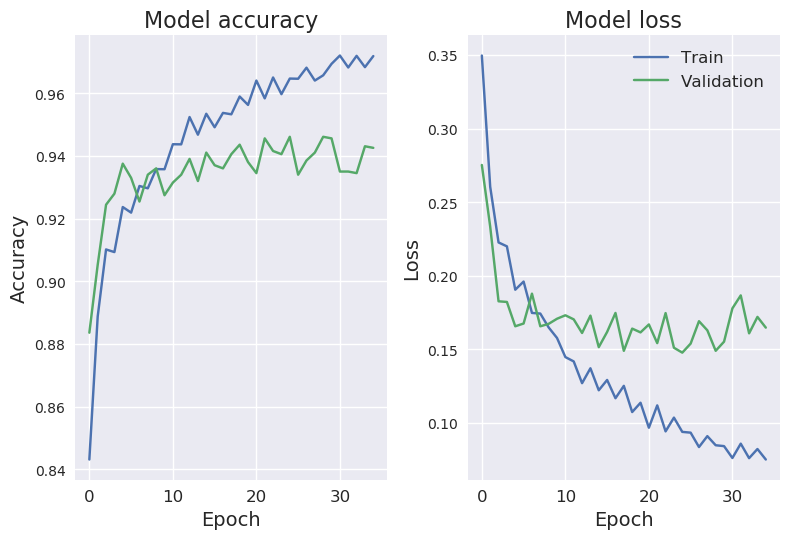

In [351]:
plt.style.use('seaborn')
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
#plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
#plt.show()
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig("./visualizations/heatmaps_training.png", dpi=200)#bbox_inches="tight", dpi=200)

In [68]:
plt.style.use("default")

In [26]:
temp1, temp2 = test_generator.next()

In [109]:
l = model.layers
conv_low_res_224 = K.function([l[0].input, K.learning_phase()], [l[-3].output])
temp = conv_low_res_224([temp1])[0]#.shape

In [110]:
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1)
    else:
        return np.rollaxis(img, 0, 3)

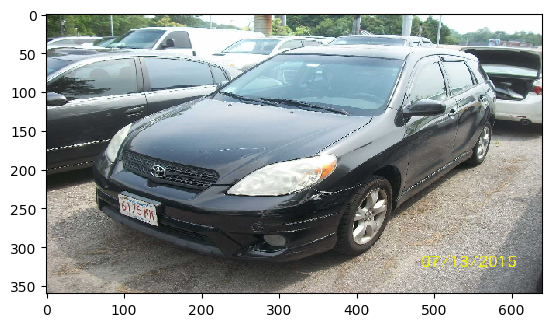

In [111]:
index = 12
plot(temp1[index])

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


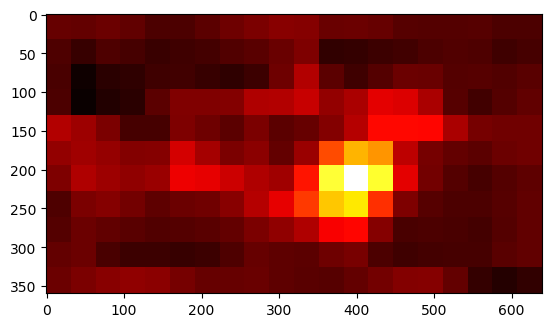

In [112]:
tmptest = scipy.misc.imresize(temp[index][0], target_size, interp='nearest')
plt.imshow(tmptest, cmap="hot")

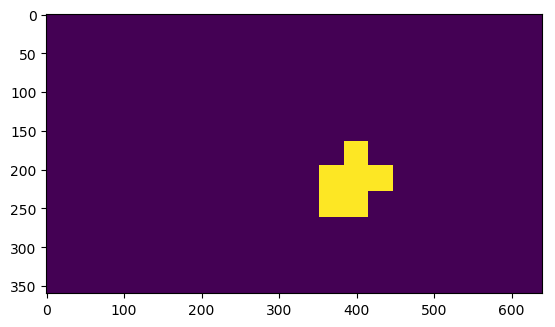

In [113]:
plt.imshow(tmptest>150)

In [119]:
model.evaluate_generator(
        test_generator,
        steps=125
)

[0.16652407319052145, 0.942]

### Reload results (top-model, high-resolution)

If the results have been computed before.

In [ ]:
target_size = (360,640)

In [ ]:
conv_trn_feat_640 = load_array(path+'results/vgg/con_trn_feat_640.dat')
conv_val_feat_640 = load_array(path+'results/vgg/conv_val_feat_640.dat')

In [ ]:
nf=128; p=0.
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_trn_feat_640.shape[1:]),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,(3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

top_model = Sequential(get_lrg_layers())
top_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

top_model.load_weights(filepath=path+'results/models/top_model_high_res_640.hdf5')

In [ ]:
loss, acc = top_model.evaluate(conv_val_feat_640, val_labels, batch_size=batch_size)
print(loss, acc)
all_results["VGG model, size=(360,640), no Maxpooling"]["validation accuracy"] = np.round(acc, 2)

### Heatmap high-resolution

In [ ]:
l = top_model.layers
conv_high_res_640 = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [ ]:
l

In [ ]:
def get_cm(inp, label, conv_output, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_output([inp,0])[0][0, label]
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)

def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [ ]:
index = 354  # 9, 12

In [ ]:
inp = np.expand_dims(conv_val_feat_640[index], 0)
print(np.round(top_model.predict(inp)[0],2))
label = np.argmax(top_model.predict(inp)[0])

In [ ]:
label

In [ ]:
cm = get_cm(inp, label, conv_high_res_640)

In [ ]:
show_image_heatmap(index, val_bbox_640, cm)

In [ ]:
#plt.imshow(to_plot(val[index]))
#plt.show()
#show_bb(index, val_bbox_640)

In [ ]:
# 'height', 'width', 'x', 'y'
# xmin
print(val_bbox_640[index][2])
# xmax
print(val_bbox_640[index][2] + val_bbox_640[index][1])
# ymin
print(val_bbox_640[index][3])
# ymax
print(val_bbox_640[index][3] + val_bbox_640[index][0])

In [ ]:
#plt.imshow(cm, cmap="hot")
#plt.show()
#plt.colorbar()

### Results

In [ ]:
def select_top_k(cm, k):
    return np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]


def get_cm(inp, label, conv_output, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_output([inp,0])[0][0, label]
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)


# Compute all the inps.
# Compute all the cms.
# Select the k pixel coordinates with the lowest values.
# Check if those coordinates are inside the bounding box.
# Compute the total p@k.
# (We can store the p@k for every image in a list).

def get_all_cms(conv_val_feat, model):
    l = top_model.layers
    conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    
    index_range = conv_val_feat.shape[0]
    # print(index_range)
    inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    
    cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    return cms


def total_p_at_k(cms, val_bbox, k):
    # l = top_model.layers
    # conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    # 
    index_range = len(cms)
    # # print(index_range)
    # inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    # labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    # 
    # cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    top_ks = [select_top_k(cm, k) for cm in cms]
    
    #return top_ks
    
    #print("bounding box")
    xmins = [val_bbox[index][2] for index in range(index_range)]
    xmaxs = [val_bbox[index][2] + val_bbox[index][1] for index in range(index_range)]
    ymins = [val_bbox[index][3] for index in range(index_range)]
    ymaxs = [val_bbox[index][3] + val_bbox[index][0] for index in range(index_range)]
    #return [[72 <= x[1] <= 107 and 34 <= x[0] <= 55 for x in top_ks[1]]
    #             for y in top_ks]
    #print("ks_inside")
    ks_inside = [[xmin <= x[1] <= xmax and ymin <= x[0] <= ymax for x in y]
                 for y, xmin, xmax, ymin, ymax in zip(top_ks, xmins, xmaxs, ymins, ymaxs)
                 if xmin!=0 and xmax!=0 and ymin!=0 and ymax!=0]
    
    p_at_ks = [np.mean(k_inside) for k_inside in ks_inside]
    
    #print(p_at_ks)
    
    #return ks_inside
    
    return np.mean(p_at_ks)

In [ ]:
cms = get_all_cms(conv_val_feat_640, top_model)

In [ ]:
k = 1
all_results["VGG model, size=(360,640), no Maxpooling"]["p@{}".format(k)] = np.round(total_p_at_k(cms, val_bbox_640, k), 2)

In [ ]:
threshold = 150
all_results["VGG model, size=(360,640), no Maxpooling"]["ratio among region"] = np.round(p_among_region(cms, val_bbox_640, threshold), 2)
all_results["VGG model, size=(360,640), no Maxpooling"]["ratio among all regions"] = np.round(p_among_all_regions(cms, val_bbox_640, threshold), 2)

CAREFUL : recompile the get_cm function each time you change models or remove the default value of the target_size argument.

In [ ]:
# 'height', 'width', 'x', 'y'
# xmin
print(val_bbox[index][2])
# xmax
print(val_bbox[index][2] + val_bbox[index][1])
# ymin
print(val_bbox[index][3])
# ymax
print(val_bbox[index][3] + val_bbox[index][0])

## Class Activation Maps

In [ ]:
target_size = (360,640)

trn = load_array(path+'results/data/trn_640.dat')
val = load_array(path+'results/data/val_640.dat')

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

In [ ]:
target_size = (360,640)

In [ ]:
conv_trn_feat_640 = load_array(path+'results/vgg/con_trn_feat_640.dat')
conv_val_feat_640 = load_array(path+'results/vgg/conv_val_feat_640.dat')

In [ ]:
nf=128; p=0.
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_trn_feat_640.shape[1:]),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,(3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

top_model = Sequential(get_lrg_layers())
top_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

top_model.load_weights(filepath=path+'results/models/top_model_high_res_640.hdf5')

In [ ]:
loss, acc = top_model.evaluate(conv_val_feat_640, val_labels, batch_size=batch_size)
print(loss, acc)
all_results["VGG model, size=(360,640), with CAM"]["validation accuracy"] = np.round(acc, 2)

### Heatmap high-resolution

In [ ]:
l = top_model.layers
conv_high_res_640 = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [ ]:
def get_cm(inp, labels, conv_output, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_output([inp,0])[0][0, :]
    #print(conv.shape)
    #print(labels.shape)
    # "labels @ conv" and not "conv @ label" as "channel_first".
    # "np.expand_dims" to have a size of (8,1) instead of (8,).
    # conv = np.expand_dims(labels, 1).T @ conv
    conv = np.tensordot(labels, conv, axes=1)
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)

def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [ ]:
index = 2

In [ ]:
inp = np.expand_dims(conv_val_feat_640[index], 0)
print(np.round(top_model.predict(inp)[0],2))
labels = top_model.predict(inp)[0]

In [ ]:
np.expand_dims(labels, 1).shape

In [ ]:
cm = get_cm(inp, labels, conv_high_res_640)

In [ ]:
cm.shape

In [ ]:
show_image_heatmap(index, val_bbox_640, cm)

### Results

In [ ]:
# def select_top_k(cm, k):
#     return np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]
# 
# 
# # Compute all the inps.
# # Compute all the cms.
# # Select the k pixel coordinates with the lowest values.
# # Check if those coordinates are inside the bounding box.
# # Compute the total p@k.
# # (We can store the p@k for every image in a list).
# 
# def total_p_at_k(conv_val_feat, model, k):
#     l = top_model.layers
#     conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
#     
#     index_range = conv_val_feat.shape[0]
#     # print(index_range)
#     inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
#     all_labels = [top_model.predict(inp)[0] for inp in inps]
#     
#     cms = [get_cm(inp, labels, conv_output) for inp, labels in zip(inps, all_labels)]
#     
#     top_ks = [select_top_k(cm, k) for cm in cms]
#     
#     #return top_ks
#     
#     #print("bounding box")
#     xmins = [val_bbox_640[index][2] for index in range(index_range)]
#     xmaxs = [val_bbox_640[index][2] + val_bbox_640[index][1] for index in range(index_range)]
#     ymins = [val_bbox_640[index][3] for index in range(index_range)]
#     ymaxs = [val_bbox_640[index][3] + val_bbox_640[index][0] for index in range(index_range)]
#     #return [[72 <= x[1] <= 107 and 34 <= x[0] <= 55 for x in top_ks[1]]
#     #             for y in top_ks]
#     #print("ks_inside")
#     ks_inside = [[xmin <= x[1] <= xmax and ymin <= x[0] <= ymax for x in y]
#                  for y, xmin, xmax, ymin, ymax in zip(top_ks, xmins, xmaxs, ymins, ymaxs)
#                  if xmin!=0 and xmax!=0 and ymin!=0 and ymax!=0]
#     
#     p_at_ks = [np.mean(k_inside) for k_inside in ks_inside]
#     
#     #print(p_at_ks)
#     
#     #return ks_inside
#     
#     return np.mean(p_at_ks)

In [ ]:
def select_top_k(cm, k):
    return np.dstack(np.unravel_index(np.argsort(cm.ravel()), target_size))[0][-k:]


def get_cm(inp, labels, conv_output, target_size=target_size):
    # Better beaviour with scipy.misc.resize than with skimage.transform.resize,
    # we will use it, even though it is deprecated.
    conv = conv_output([inp,0])[0][0, :]
    #print(conv.shape)
    #print(labels.shape)
    # "labels @ conv" and not "conv @ label" as "channel_first".
    # "np.expand_dims" to have a size of (8,1) instead of (8,).
    # conv = np.expand_dims(labels, 1).T @ conv
    conv = np.tensordot(labels, conv, axes=1)
    # print(conv.shape)
    #return conv
    return scipy.misc.imresize(conv, target_size, interp='nearest')
    #return skimage.transform.resize(conv.astype('int'), target_size)


# Compute all the inps.
# Compute all the cms.
# Select the k pixel coordinates with the lowest values.
# Check if those coordinates are inside the bounding box.
# Compute the total p@k.
# (We can store the p@k for every image in a list).

def get_all_cms(conv_val_feat, model):
    l = top_model.layers
    conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    
    index_range = conv_val_feat.shape[0]
    # print(index_range)
    inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    all_labels = [top_model.predict(inp)[0] for inp in inps]
    
    cms = [get_cm(inp, labels, conv_output) for inp, labels in zip(inps, all_labels)]
    
    return cms


def total_p_at_k(cms, val_bbox, k):
    # l = top_model.layers
    # conv_output = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    # 
    index_range = len(cms)
    # # print(index_range)
    # inps = [np.expand_dims(conv_val_feat[index], 0) for index in range(index_range)]
    # labels = [np.argmax(top_model.predict(inp)[0]) for inp in inps]
    # 
    # cms = [get_cm(inp, label, conv_output) for inp, label in zip(inps, labels)]
    
    top_ks = [select_top_k(cm, k) for cm in cms]
    
    #return top_ks
    
    #print("bounding box")
    xmins = [val_bbox[index][2] for index in range(index_range)]
    xmaxs = [val_bbox[index][2] + val_bbox[index][1] for index in range(index_range)]
    ymins = [val_bbox[index][3] for index in range(index_range)]
    ymaxs = [val_bbox[index][3] + val_bbox[index][0] for index in range(index_range)]
    #return [[72 <= x[1] <= 107 and 34 <= x[0] <= 55 for x in top_ks[1]]
    #             for y in top_ks]
    #print("ks_inside")
    ks_inside = [[xmin <= x[1] <= xmax and ymin <= x[0] <= ymax for x in y]
                 for y, xmin, xmax, ymin, ymax in zip(top_ks, xmins, xmaxs, ymins, ymaxs)
                 if xmin!=0 and xmax!=0 and ymin!=0 and ymax!=0]
    
    p_at_ks = [np.mean(k_inside) for k_inside in ks_inside]
    
    #print(p_at_ks)
    
    #return ks_inside
    
    return np.mean(p_at_ks)

In [ ]:
cms = get_all_cms(conv_val_feat_640, top_model)

In [ ]:
k = 1
all_results["VGG model, size=(360,640), with CAM"]["p@{}".format(k)] = np.round(total_p_at_k(cms, val_bbox_640, k), 2)

In [ ]:
threshold = 150
all_results["VGG model, size=(360,640), with CAM"]["ratio among region"] = np.round(p_among_region(cms, val_bbox_640, threshold), 2)
all_results["VGG model, size=(360,640), with CAM"]["ratio among all regions"] = np.round(p_among_all_regions(cms, val_bbox_640, threshold), 2)

## Other metric

In [ ]:
plt.imshow(cm, cmap='hot')
plt.colorbar()

In [ ]:
tmp = np.gradient(cm)

In [ ]:
plt.imshow(blobs)

In [ ]:
plt.imshow(tmp[0])

In [ ]:
plt.imshow(tmp[1])

In [ ]:
blobs = cm > 150

In [ ]:
labels, nlabels = ndimage.label(blobs)
labels, nlabels

In [ ]:
# r, c = np.vstack(ndimage.center_of_mass(cm, labels, np.arange(nlabels) + 1)).T  # weighted
# r, c = np.vstack(ndimage.center_of_mass(blobs, labels, np.arange(nlabels) + 1)).T  # not weighted

In [ ]:
# bb_centers = [(val_bbox_640[index][2] + val_bbox_640[index][1] / 2, val_bbox_640[index][3] + val_bbox_640[index][0])
#              for index in range(conv_val_feat_640.shape[0])]

In [ ]:
val_bbox_640[index]

In [ ]:
# TODO : move functions higher

In [ ]:
def p_among_region(cms, val_bbox, threshold):
    """
    Computes (# pixels in the bounding box) / (# pixels in the same region)
    for all pixels which have values higher than a given threshold.
    """
    index_range = len(cms)
    
    # Compute all the blobs: masks whith 1 for every pixel with values higher than threshold,
    # 0 otherwise.
    all_blobs = [cm > threshold for cm in cms]
    
    # Compute all the xmins, xmaxs, ymins and ymaxs of the bounding boxes (edges).
    xmins = [val_bbox[index][2] for index in range(index_range)]
    xmaxs = [val_bbox[index][2] + val_bbox[index][1] for index in range(index_range)]
    ymins = [val_bbox[index][3] for index in range(index_range)]
    ymaxs = [val_bbox[index][3] + val_bbox[index][0] for index in range(index_range)]
    
    # Detect all the regions in the blobs.
    all_labels = [ndimage.label(blobs) for blobs in all_blobs]
    
    # Detect the coordinates of the pixels, with higher values than threshold,
    # that are inside the bounding box.
    all_pixels_in_bb = [np.array([int(np.floor(xmin)), int(np.floor(ymin))]) + \
                        np.transpose(np.nonzero(blobs[int(np.floor(xmin)):int(np.ceil(xmax)), int(np.floor(ymin)):int(np.floor(ymax))]))
                       for blobs, xmin, xmax, ymin, ymax in zip(all_blobs, xmins, xmaxs, ymins, ymaxs)]
    
    # If there are pixels inside the bounding box, determine which region they belong to.
    corresponding_blobs = [None if x.size==0 else label[0][x[0][0],x[0][1]] for label, x in zip(all_labels, all_pixels_in_bb)]
    
    # Compute how many pixels there are in the region the pixel belongs to.
    region_num_pixels = np.array([np.inf if num_blob is None else np.where(label[0]==num_blob)[0].shape[0] \
                                  for label, num_blob in zip(all_labels, corresponding_blobs)])
    
    # Compute how many pixels are inside the bounding box.
    num_pixels_in_bb = np.array([x.shape[0] for x in all_pixels_in_bb])
    
    # Compute the mean of (# pixels in the bounding box) / (# pixels in the same region).
    return np.mean(num_pixels_in_bb / region_num_pixels)

In [ ]:
p_among_region(cms, val_bbox_640, 150)

In [ ]:
def p_among_all_regions(cms, val_bbox, threshold):
    """
    Computes (# pixels in the bounding box) / (# pixels with values higher than a given threshold).
    """
    index_range = len(cms)
    # total_num_pixels = cms[0].size  # total number of pixels
    
    # Compute all the blobs: masks whith 1 for every pixel with values higher than threshold,
    # 0 otherwise.
    all_blobs = [cm > threshold for cm in cms]
    
    # Compute all the xmins, xmaxs, ymins and ymaxs of the bounding boxes (edges).
    xmins = [val_bbox[index][2] for index in range(index_range)]
    xmaxs = [val_bbox[index][2] + val_bbox[index][1] for index in range(index_range)]
    ymins = [val_bbox[index][3] for index in range(index_range)]
    ymaxs = [val_bbox[index][3] + val_bbox[index][0] for index in range(index_range)]
    
    # Detect the coordinates of the pixels, with higher values than threshold,
    # that are inside the bounding box.
    # Note that those are only "relative" coordinates: coordinates of the crop of the image,
    # to only the bounding box part, not coordinates in the original image,
    # as we do not need them (as opposed to the function p_among_region).
    all_pixels_in_bb = [np.transpose(np.nonzero(blobs[int(np.floor(xmin)):int(np.ceil(xmax)), int(np.floor(ymin)):int(np.floor(ymax))]))
                       for blobs, xmin, xmax, ymin, ymax in zip(all_blobs, xmins, xmaxs, ymins, ymaxs)]
    
    # Compute how many pixels are inside the bounding box.
    num_pixels_in_bb = np.array([x.shape[0] for x in all_pixels_in_bb])
    
    # Compute how many pixels have values higher than threshold.
    total_num_pixels = np.array([np.count_nonzero(blob) for blob in all_blobs])
    
    # Compute the mean of (# pixels in the bounding box) / (# pixels with values higher than threshold).
    return np.mean(num_pixels_in_bb / total_num_pixels)

In [ ]:
# Discuss : should we take the mean / total_num_pixels

p_among_all_regions(cms, val_bbox_640, 150)

In [ ]:
weights = [1,2]

target = np.array([ [[0.0,1.0],[1.0,0.0]],
                    [[0.0,1.0],[1.0,0.0]]])

output = np.array([ [[0.5,0.5],[0.9,0.1]],
                    [[0.9,0.1],[0.4,0.6]]])

crossentropy_matrix = -np.sum(target * np.log(output), axis=-1)
print(crossentropy_matrix)
crossentropy = -np.sum(target * np.log(output))
crossentropy

## Crop

In [ ]:
tmp_mat = np.array([[0,1,1],[0,1,1],[0,0,0]])
tmp_mat

In [149]:
~np.all(tmp_mat == 0, axis=1)  # rows

array([ True,  True, False])

In [150]:
~np.all(tmp_mat == 0, axis=0)  # columns

array([False,  True,  True])

In [146]:
tmp_mat_crop = tmp_mat[~np.all(tmp_mat == 0, axis=1)]
tmp_mat_crop

array([[0, 1, 1],
       [0, 1, 1]])

In [147]:
tmp_mat_crop[:, ~np.all(tmp_mat_crop == 0, axis=0)]

array([[1, 1],
       [1, 1]])

In [293]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATH_IMAGES+"test/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 4000 images belonging to 2 classes.


In [116]:
test_generator.n//test_generator.batch_size

4000

In [121]:
model.evaluate_generator(
        test_generator,
        steps=4000
)

[0.16652396629480398, 0.942]

In [295]:
temp1, temp2 = test_generator.next()

In [296]:
l = model.layers
conv_low_res_224 = K.function([l[0].input, K.learning_phase()], [l[-3].output])
temp = conv_low_res_224([temp1])[0]

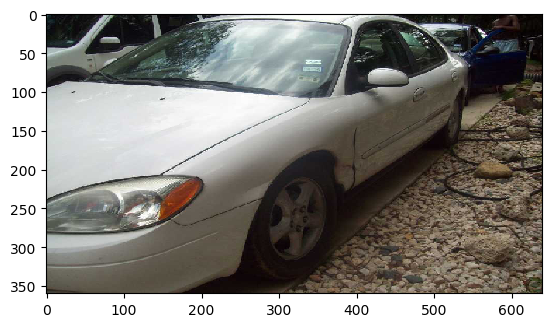

In [297]:
plot(temp1[0])

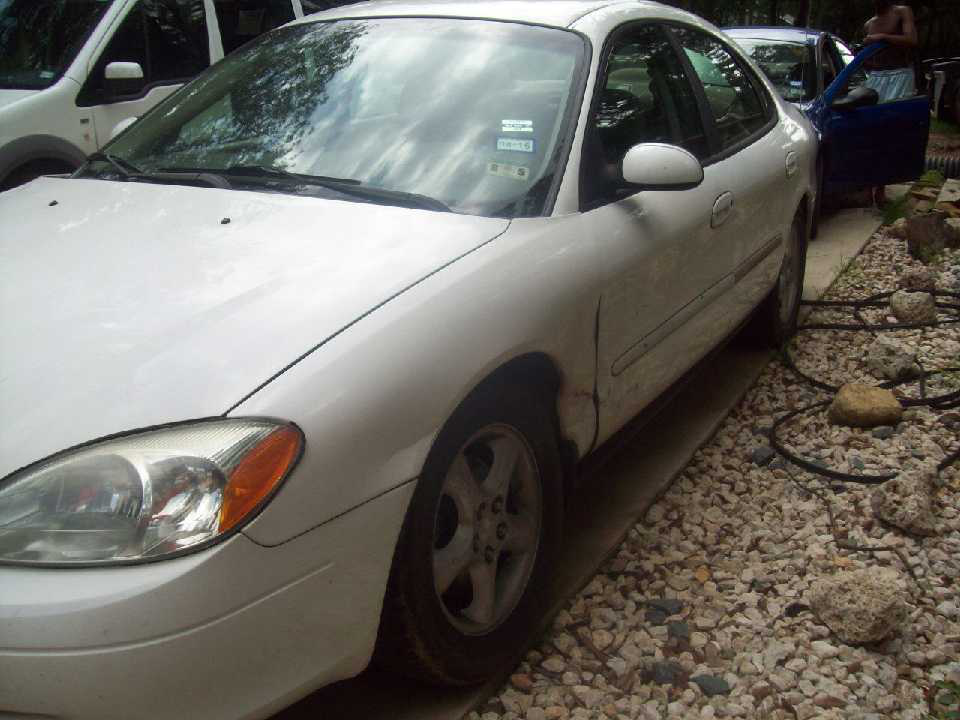

In [298]:
img_test = PIL.Image.open(PATH_IMAGES+"test/"+test_generator.filenames[1])
img_test

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


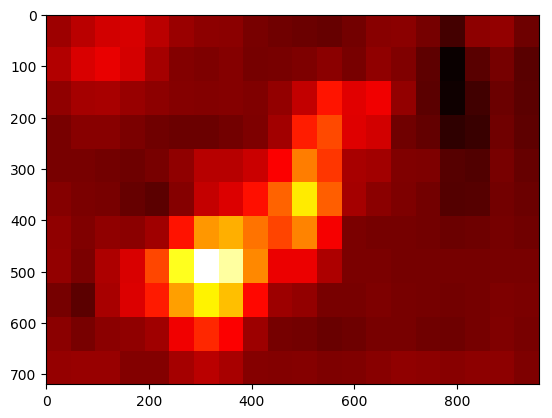

In [299]:
tmptest = scipy.misc.imresize(temp[0][0], (img_test.size[1], img_test.size[0]), interp='nearest')
plt.imshow(tmptest, cmap="hot")

In [211]:
heatmap.shape

(1, 2, 11, 20)

In [213]:
np.argmax(model.predict(temp1))

0

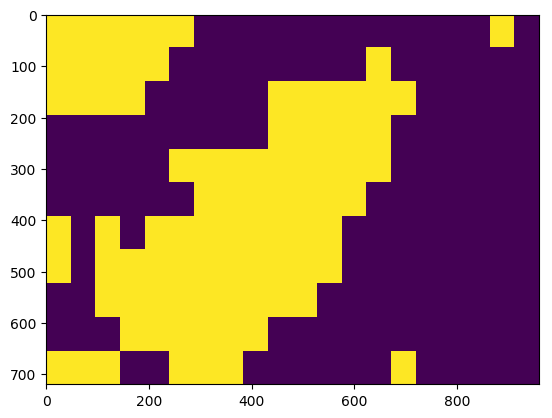

In [347]:
blob = tmptest > 50
blob_150 = tmptest > 150
blob_100 = tmptest > 100
blob_50 = tmptest > 50
plt.imshow(blob)

In [320]:
check_rows = ~np.all(blob == 0, axis=1)
non_zero_rows = np.where(check_rows)[0]
xmin = non_zero_rows[0]
xmax = non_zero_rows[-1]

check_cols = ~np.all(blob == 0, axis=0)
non_zero_cols = np.where(check_cols)[0]
ymin = non_zero_cols[0]
ymax = non_zero_cols[-1]

In [140]:
non_zero_cols

array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 320,
       321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415])

In [288]:
(xmin, ymin, xmax, ymax)

(70, 282, 243, 460)

In [241]:
test_generator.filenames

['flwing/000083b5-e5c1-5bbb-b181-409c3ad57af1.jpg',
 'flwing/0002288b-3b3e-59a1-83b6-a3528d9dc889.jpg',
 'flwing/00029f7b-9ed4-5f54-8cf6-5cb077db0e36.jpg',
 'flwing/000401ed-c11b-5875-9f36-43654f525391.jpg',
 'flwing/00093c31-c931-58ba-a655-570dcea4335c.jpg',
 'flwing/000a06dd-81d3-53be-b7bf-9a83a849a438.jpg',
 'flwing/000b87cb-b5b5-5b40-be2a-46e7ab189c3a.jpg',
 'flwing/000bfef6-0ac8-52a8-a266-1ee9a9d1785f.jpg',
 'flwing/000c5049-35b0-5fef-bc66-f2e323851cb4.jpg',
 'flwing/000cc95c-bf73-54ab-9f89-2c237424b721.jpg',
 'flwing/000d01e4-a9b2-56ce-aa91-2e4d37e287a0.jpg',
 'flwing/000dbd56-768a-5859-8be9-ccd629ce73f2.jpg',
 'flwing/000fe8f2-493c-5b9f-9364-1e00b6edd624.jpg',
 'flwing/00100887-8dad-5efa-8084-1ac0f9b5b757.jpg',
 'flwing/00116eea-71f3-5d0b-ab89-200da19a1cd9.jpg',
 'flwing/0012a8c6-8dad-5122-b926-7035909dae94.jpg',
 'flwing/0012cf4d-a697-5f90-b756-df9b9601adbc.jpg',
 'flwing/00148565-058b-56ba-a039-d3315a3fa98f.jpg',
 'flwing/00178535-d943-511e-ae0f-f163d8fafc14.jpg',
 'flwing/001

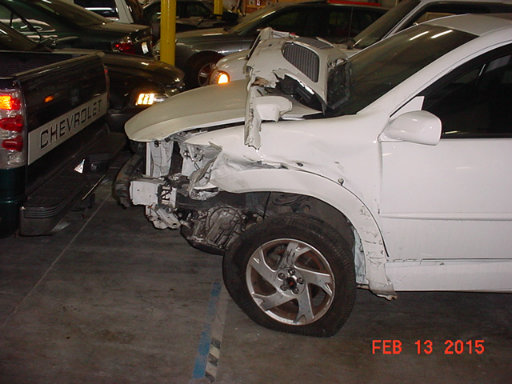

In [280]:
img_test = PIL.Image.open(PATH_IMAGES+"test/"+test_generator.filenames[2])
img_test

In [321]:
#img_test = PIL.Image.open(PATH_IMAGES+"/test/flwing/0000befa-6401-5205-a533-f2466b83fd6c.jpg")
#img_test = PIL.Image.open(PATH_IMAGES+"test/"+test_generator.filenames[2])
#img_test.crop((xmin,ymin,xmax,ymax))
img_test_crop_50 = img_test.crop((ymin,xmin,ymax,xmax))

In [342]:
import matplotlib as mpl

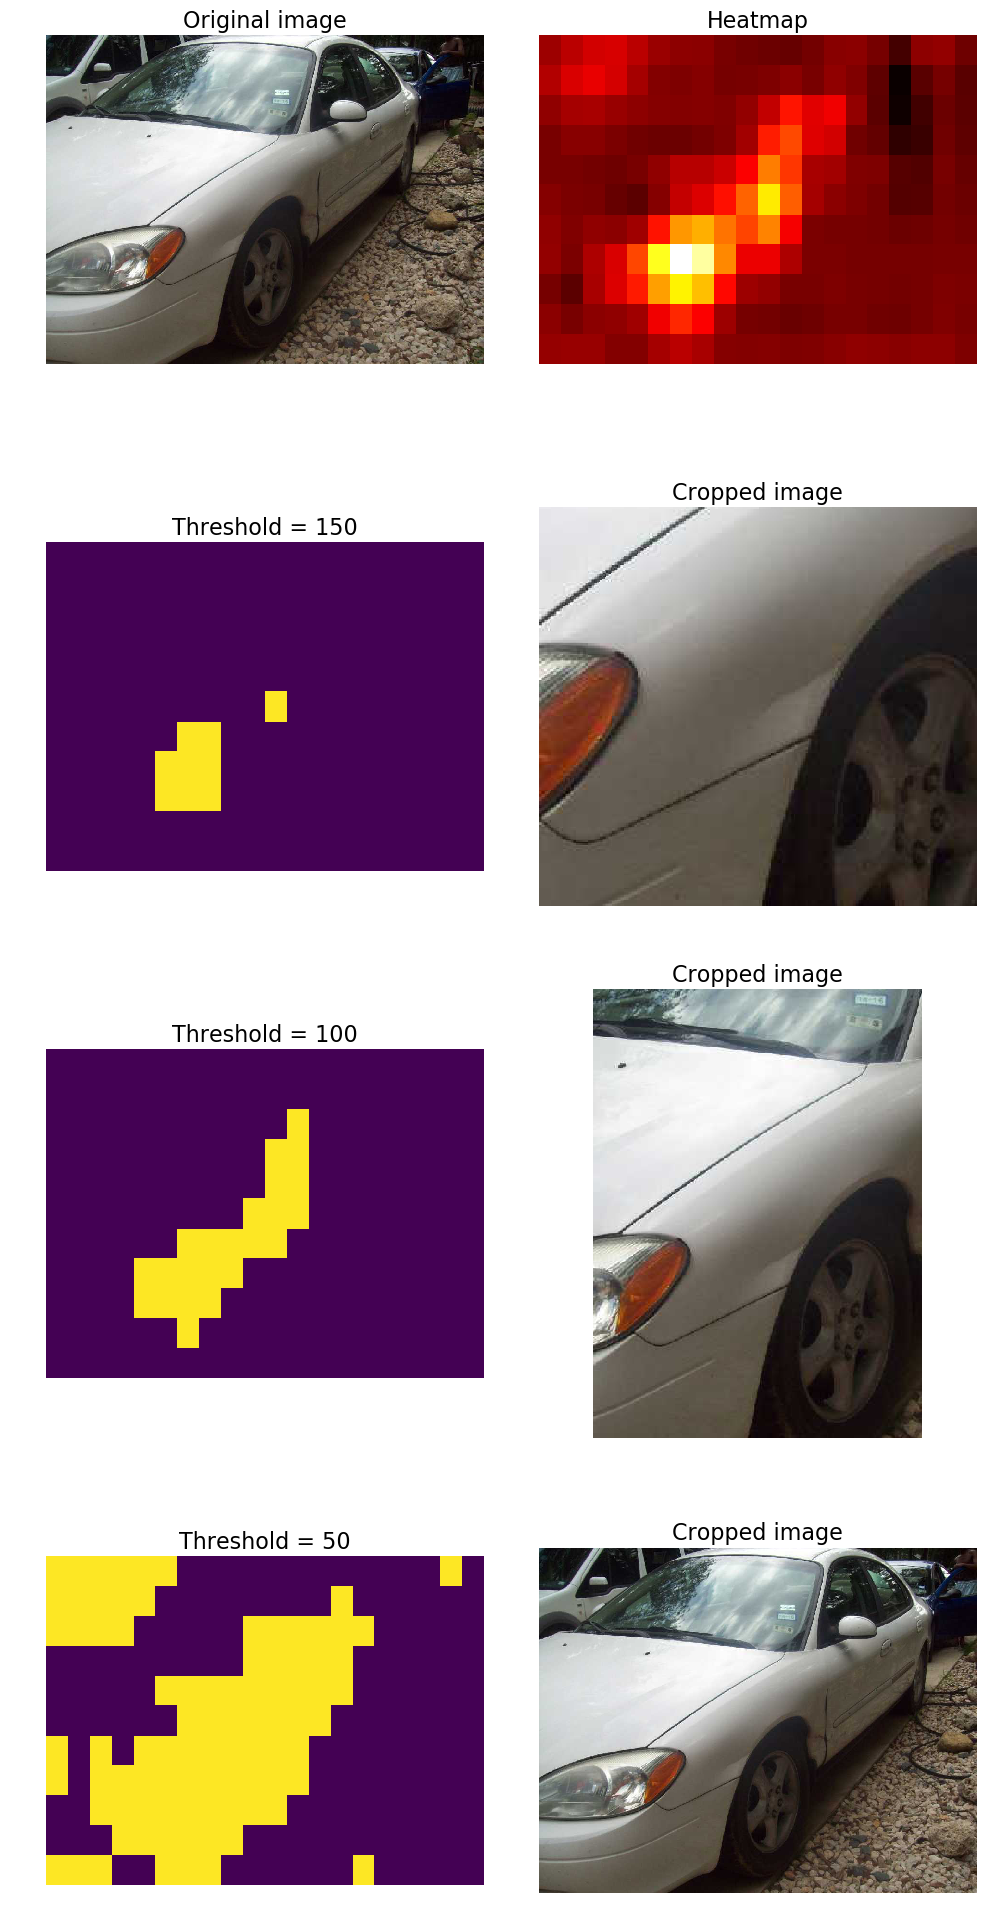

In [344]:
fontdict = {'fontsize': 16,
            'fontweight' : mpl.rcParams['axes.titleweight'],
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}

f = plt.figure(figsize=(10,20))
ax1 = f.add_subplot(421)
ax2 = f.add_subplot(422)
ax3 = f.add_subplot(423)
ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425)
ax6 = f.add_subplot(426)
ax7 = f.add_subplot(427)
ax8 = f.add_subplot(428)

ax1.imshow(img_test)
ax1.set_title("Original image", fontdict=fontdict)
ax1.axis("off")
ax2.imshow(tmptest, cmap="hot")
ax2.set_title("Heatmap", fontdict=fontdict)
ax2.axis("off")

ax3.imshow(blob_150)
ax3.set_title("Threshold = 150", fontdict=fontdict)
ax3.axis("off")
ax4.imshow(img_test_crop_150)
ax4.set_title("Cropped image", fontdict=fontdict)
ax4.axis("off")

ax5.imshow(blob_100)
ax5.set_title("Threshold = 100", fontdict=fontdict)
ax5.axis("off")
ax6.imshow(img_test_crop_100)
ax6.set_title("Cropped image", fontdict=fontdict)
ax6.axis("off")

ax7.imshow(blob_50)
ax7.set_title("Threshold = 50", fontdict=fontdict)
ax7.axis("off")
ax8.imshow(img_test_crop_50)
ax8.set_title("Cropped image", fontdict=fontdict)
ax8.axis("off")

#plt.subplot(4,2,1,)
#plt.imshow(img_test)
#plt.axis("off")
#plt.subplot(4,2,2)
#plt.imshow(tmptest, cmap="hot")
#plt.axis("off")

#plt.subplot(4,2,3)
#plt.imshow(blob_150)
#plt.axis("off")
#plt.subplot(4,2,4)
#plt.imshow(img_test_crop_150)
#plt.axis("off")
#
#plt.subplot(4,2,5)
#plt.imshow(blob_100)
#plt.axis("off")
#plt.subplot(4,2,6)
#plt.imshow(img_test_crop_100)
#plt.axis("off")
#
#plt.subplot(4,2,7)
#plt.imshow(blob_50)
#plt.axis("off")
#plt.subplot(4,2,8)
#plt.imshow(img_test_crop_150)
#plt.axis("off")

f.tight_layout()

In [192]:
img_test.size

(960, 720)

In [193]:
target_size

(360, 640)

In [151]:
import time

In [291]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory="/home/julien/tractable_images/"+"test/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 10000 images belonging to 2 classes.


In [292]:
#all_imgs = []

for filename in test_generator.filenames:
    #start = time.time()
    img = PIL.Image.open("/home/julien/tractable_images/"+"test/"+filename)
    
    img_mat, img_label = test_generator.next()
    heatmap = conv_low_res_224([img_mat])[0]
    pred = np.argmax(model.predict(img_mat))
    heatmap_resized = scipy.misc.imresize(heatmap[0][pred], (img.size[1], img.size[0]), interp='nearest')
    blob = heatmap_resized > 100
    
    check_rows = ~np.all(blob == 0, axis=1)
    non_zero_rows = np.where(check_rows)[0]
    xmin = non_zero_rows[0]
    xmax = non_zero_rows[-1]

    check_cols = ~np.all(blob == 0, axis=0)
    non_zero_cols = np.where(check_cols)[0]
    ymin = non_zero_cols[0]
    ymax = non_zero_cols[-1]
    
    #print((xmin, ymin, xmax, ymax))
    
    img_cropped = img.crop((ymin,xmin,ymax,xmax))
    
    #print(time.time() - start)
    
    #all_imgs.append(img_cropped)
    img_cropped.save("/home/julien/crops_heatmaps_2/"+filename)

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


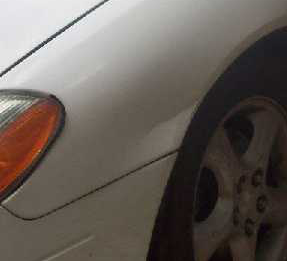

In [221]:
all_imgs[1]

## Results summary

In [ ]:
I = all_results.keys()
C = all_results["VGG model, size=(224,224), with Maxpooling"].keys()
df = pd.DataFrame(index=I, columns=C)
for (key, value), i in zip(all_results.items(), I):
    df.loc[i] = list(value.values())

df